# Remember with Expanded Experience

In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fix Random Seeds

In [2]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

In [3]:
CONTEXT_REPS = pd.read_pickle('../../data/CONTEXT_REPS_CLEAN.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
BERT_BY_IDX_DF = pd.read_pickle('../../data/bert_by_idx_pca.pkl')
BOUGHT_DICT = pd.read_pickle('../../data/bought_dict.pkl')

In [4]:
CONTEXT_REPS.shape, len(STREAM_ITEM_DICT), BERT_BY_IDX_DF.shape, len(BOUGHT_DICT)

((1333083, 219), 7701, (162189, 160), 79207)

In [5]:
USER_LIST = CONTEXT_REPS.index.get_level_values('asid').unique().tolist()

In [6]:
LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS

'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format
'''
def get_input_tensor(input_state, current_stream, with_tensor=False):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  
  # Convert to tensor
  if with_tensor: 
    stream_item_feat_tensor = df_to_tensor(stream_item_feat)
    return stream_item_feat_tensor, stream_item_feat
  else:
    return stream_item_feat

In [7]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Generate series: whether elements in A existed in list B
A, B: List
return: pd.Series
example:
  A: [1, 2, 4, 5]
  B: [1, 2, 3, 4, 5, 6, 7]
  return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
'''
def gen_exist_series(A, B):
  return [int(item in A) for item in B]

In [8]:
def df_to_tensor(input_df):
  return torch.tensor(input_df.values).to(DEVICE).float()

---

## Replay

In [9]:
class ReplayBuffer:
  def __init__(self, max_memory=100000, discount=.9, model_output_shape=1):
    """
    Setup
    max_memory: the maximum number of experiences we want to store
    memory: a list of experiences
    discount: the discount factor for future experience
    In the memory the information whether the game ended at the state is stored seperately in a nested array
    [...
    [experience, game_over]
    [experience, game_over]
    ...]
    """
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount
    self.model_output_shape = model_output_shape
    self.input_dim = 380
    self.next_state_list = {}

  def remember(self, states, game_over):
    # Save a state to memory
    current_state, reward, next_state, next_stream = states
    for i in range(len(reward)):
      self.memory.append([[current_state[i].view(1, self.input_dim), reward.iloc[i], next_state, next_stream], game_over])
      
    # We don't want to store infinite memories, so if we have too many, we just delete the oldest one
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, eval_net, target_net, structure, batch_size=10):
    # How many experiences do we have?
    len_memory = len(self.memory)
    # Dimensions of our observed states, ie, the input to our model.
    # Memory:  [
    #   [ [ [stream, next_stream], [...state], action, reward, next_state_idx], game_over],
    #   [ [ [stream, next_stream], [...state], action, reward, nexr_state_idx], game_over],
    #   ...
    # ]
    env_dim = len(INPUT_DF_COL)

    inputs = torch.tensor([], dtype=torch.float32).to(DEVICE)
    targets = torch.tensor([], dtype=torch.float32).to(DEVICE)
    
    
    # We draw states to learn from randomly
    for i, idx in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):  
      # Here we load one transition <s, a, r, s'> from memory
      state_t, reward, next_state, next_stream = self.memory[idx][0]
      game_over = self.memory[idx][1]
      
      # puts state into input
      inputs = torch.cat((inputs, state_t), dim=0)

      # if the game ended, the reward is the final reward
      if game_over:  # if game_over is True
        current_target = torch.tensor([reward]).to(DEVICE).float()
      else:
        state_tp1, _ = get_input_tensor(next_state, next_stream, with_tensor=True)
        
        if target_net == None:
          with torch.no_grad():
            Q_sa = torch.max(eval_net(state_tp1))
        elif structure == 'target':
          with torch.no_grad():
            Q_sa = torch.max(target_net(state_tp1))
        elif structure == 'double':
          with torch.no_grad():
            _, selected_actions = eval_net(state_tp1).max(dim=0, keepdim=True)
            Q_sa = target_net(state_tp1).gather(dim=0, index=selected_actions)          
        # r + gamma * max Q(s',a')
        current_target = torch.tensor([reward + self.discount * Q_sa]).to(DEVICE)
      # concat targets
      targets = torch.cat((targets, current_target), 0)
    targets = targets.view(len(targets), 1)
    return inputs, targets

## Epsilon

In [10]:
from abc import ABC, abstractmethod
import math

class Epsilon(ABC):
  @abstractmethod
  def clear(self):
    pass
  
  @abstractmethod
  def get_epsilon(self, key):
    pass
  
  @abstractmethod
  def update_at_step(self, key, data, delta):
    pass
  
  @abstractmethod
  def update_at_epoch(self, data):
    pass
  
  # @abstractmethod
  # def update_at_epsisode():
  #   pass


class Decay(Epsilon):
  # Ref: Decay(0.5, 0.85)
  '''
  Epsilon Decay EE method with update/decay at epoch
  '''
  def __init__(self, initial, epoch_decay, step_decay=1.0):
    self.initial = initial
    self.epoch_decay, self.step_decay = epoch_decay, step_decay
    self.epsilon = self.initial
    
  def clear(self):
    self.epsilon = self.initial # should be 4 for origin setting
    
  def get_epsilon(self, key):
    return self.epsilon
  
  def update_at_step(self, key, data, delta):
    # origin setting
    pass
    # exponentially
    # self.epsilon *= self.step_decay
    
  def update_at_epoch(self, data):
    # origin settings
    # epoch = data
    # self.epsilon = 4 / ((epoch + 1) ** (1 / 2))
    # exponentially
    self.epsilon *= self.epoch_decay


class VDBE(Epsilon):
  # VDBE(0.5, 0.01)
  def __init__(self, initial, sigma):
    self.initial = initial
    self.sigma = sigma

  def clear(self):
    self.epsilon = defaultdict(lambda: self.initial)

  def get_epsilon(self, key):
    return self.epsilon[key]
  
  def update_at_step(self, key, data, delta):
    td_error = data
    coeff = math.exp(-abs(td_error) / self.sigma)
    f = (1.0 - coeff) / (1.0 + coeff)
    self.epsilon[key] = delta * f + (1.0 - delta) * self.epsilon[key]
  
  def update_at_epoch(self, data):
    pass

## DQN

In [11]:
class DQN(object):
  def __init__(self, structure, exp_replay, epsilon, num_episode, epochs, batch_size, lr, switch_param_threshold, single_reward):
    self.eval_net = Net()
    self.target_net = Net() if not structure == 'vanilla' else None
    self.structure = structure
    self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
    self.loss_fn = nn.MSELoss()
    self.exp_replay = exp_replay
    self.epsilon = epsilon
    self.num_episode = num_episode
    self.epochs = epochs
    self.batch_size = batch_size
    self.switch_param_threshold = switch_param_threshold
    self.single_reward = single_reward
    self.hist = []
    self.rec_list = []
    self.ep_score_list = []
    self.current_user_hit_list = [] # current_asid's hit actions
    self.all_hit_list = [] # all asids' hist actions, asid actual buy lenght
    self.avg_hit_list = [] # avg hit/all list
    self.current_acc = []
    self.all_acc_list = []
    self.learn_step_counter = 0

  # Environment Methods
  def __episodes(self):
    # return USER_LIST[:self.num_episode]
    return np.random.choice(USER_LIST, self.num_episode, replace=False)
  
  def __user_episode_context(self):
    self.user_all_streams = CONTEXT_REPS.xs(self.asid, level="asid")
    self.stream_list = self.user_all_streams.index
    self.final_stream = max(self.stream_list)

  def reward(self):
    '''
    Comparison function for reward, 考慮「所有」歷史購買紀錄
    '''
    real_bought_ids = BOUGHT_DICT[self.asid]
    real_bought_ids_series = gen_exist_series(real_bought_ids, self.stream_items)
    
    reward_list = []
    for a, b, c in zip(real_bought_ids_series, self.action_ids, self.action_ids.index):
      reward_list.append(a & b)
      if a & b: self.current_user_hit_list.append(c)
      
    # Reward Count 
    self.rec_cnt += 1
    if sum(reward_list) > 0:
      self.win_cnt += 1
      self.ep_score += sum(reward_list)
    self.current_acc.append(sum(reward_list))

    # return list(map(lambda x: x * sum(reward_list), reward_list))
    if self.single_reward:
      return pd.Series(reward_list, index=self.stream_items)
    else:
      return pd.Series(list(map(lambda x: x * sum(reward_list), reward_list)), index=self.stream_items)

  # Agent Methods
  def __choose_actions(self):
    if np.random.rand() <= self.epsilon.get_epsilon(self.asid):
    # if len(self.exp_replay.memory) < 1:
      # Explore by randomly select 10/n items from candidate_items
      # Get all items from the stream
      self.explore += 1
      selected_actions = random.sample(self.stream_items, 10) if len(self.stream_items) > 10 else self.stream_items
    else:
      # Exploit by choosing action from the model's prediction
      self.exploit += 1
      selected_actions = self.__agent_predict()
    x = pd.Series(0, index=self.stream_items)
    x.loc[selected_actions] = 1
    return x
    
  def q_value(self): 
    if type(self.epsilon) == Decay: return 0
    with torch.no_grad():
      predicts = self.eval_net(self.full_input).flatten()    
    actions_idx = np.where(self.action_ids.values == 1)[0]
    q_val = predicts[actions_idx].mean()
    return q_val

  def __agent_predict(self):
    with torch.no_grad():
      predicts = self.eval_net(self.full_input).flatten()
    if len(predicts) > 10:
      top10_idx = torch.topk(predicts, 10).indices.cpu()
      actions = self.candidate_actions.iloc[top10_idx]['item_id'].values
    else:
      actions = self.candidate_actions['item_id'].values
    return actions

  def __train_agent_batch(self, inputs, targets):
    self.optimizer.zero_grad()
    outputs = self.eval_net(inputs)
    loss = self.loss_fn(outputs, targets)
    # Add CL Regularization Term
    loss.backward()
    self.optimizer.step()
    return loss.item()

  # MAIN TRAIN
  def train(self):
    self.eval_net.to(DEVICE)
    if self.target_net:
      self.target_net.to(DEVICE)
    self.eval_net.train(True)
    self.epsilon.clear()

    for e in self.epochs:
      self.rec_cnt = 0
      self.win_cnt = 0
      self.loss = 0.
      self.ep_score = 0
      self.explore = 0
      self.exploit = 0

      print(f'Epoch {e} started.   Time: {datetime.now(pytz.timezone("Asia/Taipei")).strftime("%H:%M:%S")}')
      # ------------------- Episode (User) -------------------------------
      for asid in tqdm(self.__episodes()):
        self.asid = asid
        self.__user_episode_context()

        # ----------------- Runs (User x All_Stream) ---------------------
        for i, stream in enumerate(self.stream_list):
          game_over = stream == self.final_stream
          self.current_stream = stream
          self.current_state = self.user_all_streams.loc[stream]
          self.stream_items = STREAM_ITEM_DICT[self.current_stream]
          self.full_input, self.candidate_actions = get_input_tensor(self.current_state, self.current_stream, with_tensor=True)

          # --------------- Explore/Exploit Section ----------------------
          self.action_ids = self.__choose_actions()

          # --------------- Get next state & info to store ---------------
          reward = self.reward()
          # Calculate score for each users
          if game_over:
            self.all_hit_list.append([len(set(self.current_user_hit_list)), len(BOUGHT_DICT[self.asid])])
            self.current_user_hit_list = []
            self.all_acc_list.append(self.current_acc)
            self.current_acc = []

          next_state = self.user_all_streams.loc[self.stream_list[i + 1]] if not game_over else []
          next_stream = None if (i + 1) == len(self.stream_list) else self.stream_list[i + 1]
          # if next_stream is None:
          #   next_state = []
          # else: 
          #   next_state, _ = get_input_tensor(next_state, next_stream, with_tensor=True)
          
          self.exp_replay.remember([self.full_input, reward, next_state, next_stream], game_over)
          # for updating target network
          self.learn_step_counter += 1
          if self.target_net and (self.learn_step_counter % self.switch_param_threshold == 0):
            self.target_net.load_state_dict(self.eval_net.state_dict())


          # --------------- Load batch of experiences --------------------
          inputs, targets = self.exp_replay.get_batch(self.eval_net, self.target_net, self.structure, batch_size=self.batch_size)
          
          # store pre-training value for td_error
          old_Q = self.q_value()
          batch_loss = self.__train_agent_batch(inputs, targets)
          # store post-training value for td_error
          new_Q = self.q_value()
          self.loss += batch_loss

          # --------------- Update with TD error -------------------------
          self.epsilon.update_at_step(self.asid, (new_Q - old_Q), len(self.stream_items))
          
      self.epsilon.update_at_epoch(e)

      # Track win history to later check if our model is improving at the game over time.
      self.hist.append(self.win_cnt)
      self.rec_list.append(self.rec_cnt)
      self.ep_score_list.append(self.ep_score)

      print(f'Epoch: {e}/{len(self.epochs)} | Loss {self.loss:.2f} | Epoch Hit Rate {(self.win_cnt/self.rec_cnt):.2f} | \
Cumulative Hit Rate {(sum(self.hist)/sum(self.rec_list)):.2f} | Explore {self.explore} | Exploit {self.exploit} | \
Score {self.ep_score} | Rec_cnt: {self.rec_cnt}')
      start = e * 100
      end = start + 100
      hit = [a[0] for a in self.all_hit_list[start:end]]
      bought = [a[1] for a in self.all_hit_list[start:end]]
      print(sum(hit)/sum(bought))
      self.avg_hit_list.append(sum(hit)/sum(bought))

## Main Method

In [12]:
pd.set_option('mode.chained_assignment', None)

# parameters
MAX_MEMORY = 10000  # Maximum number of experiences we are storing
BATCH_SIZE = 50  # Number of experiences we use for training per batch
EPOCH = range(100)
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
LR = 1.0e-3
SWITCH_PARAM_THRESHOLD = 100

warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(380, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.tanh(x)
    x = self.fc5(x)
    return x

## Exp: single experience

In [15]:
'''
EPS_target_rsum_x_positive

- VDBE(0.5, 0.01)
- Decay(0.5, 0.85)
'''

exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon = Decay(0.99, 0.92)
dqn_test2 = DQN('target', exp_replay, epsilon, 
                                  NUM_EPISODE, EPOCH, BATCH_SIZE, 
                                  LR, SWITCH_PARAM_THRESHOLD, single_reward=False)
dqn_test2.train()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.93 GiB total capacity; 4.00 GiB already allocated; 5.75 MiB free; 4.02 GiB reserved in total by PyTorch)

In [107]:
hit = [a[0] for a in EPS_target_rsum_x_positive.all_hit_list]
bought = [a[1] for a in EPS_target_rsum_x_positive.all_hit_list]

In [100]:
sum(hit)/sum(bought)

0.16709346991037133

In [32]:
# baseline100 = pd.read_pickle('../Experiments Results/res_baseline_100_vanilla.pkl')

In [18]:
res = [a/b for a, b in zip(dqn_test.hist, dqn_test.rec_list)]

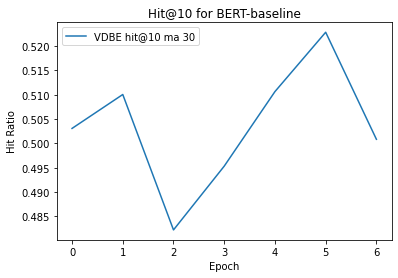

In [19]:
# plt.plot(EPS_target_rsum_x_positive.ep_score_list, label='hit')
# plt.plot(EPS_target_rsum_x_positive.avg_hit_list, label='res')
plt.plot(res, label='VDBE hit@10 ma 30')
# for l in re:
#   print(l)
#   plt.axvline(x = l, color = 'red')
# plt.plot(pd.Series(bought).rolling(1000).mean(), label='VDBE hit@10 ma 30')
plt.xlabel('Epoch')
plt.ylabel('Hit Ratio')
plt.title('Hit@10 for BERT-baseline')
# plt.ylim([0.4, 0.6])
plt.legend()

In [44]:
with open('../Models/EPS_target_rsum_x_positive.pkl', 'wb') as file_pi:
  pickle.dump(EPS_target_rsum_x_positive, file_pi, pickle.HIGHEST_PROTOCOL)

In [17]:
'''
請不要關掉這ㄍ分頁 乾蝦哈咪搭
'''

'\n請不要關掉這ㄍ分頁 乾蝦哈咪搭\n'

In [135]:
asd = pd.read_pickle('../Models/EPS_target_rsum_x_positive.pkl')

In [86]:
re

72

In [88]:
res1 = 0
re = []
for a in length:
  res1 += a
  re.append(res1)
re

[18, 22, 32, 36, 50, 61, 126, 141, 200, 272]

In [73]:
length = [len(a) for a in dqn_test2.all_acc_list]

In [81]:
res = [a/10 for a in res]

In [80]:
res = [item for sublist in dqn_test2.all_acc_list for item in sublist]

In [22]:
%load_ext line_profiler

In [71]:
exp_replay2 = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon2 = Decay(0.99, 0.92)
dqn_test2 = DQN('target', exp_replay2, epsilon2, 
                10, range(1), BATCH_SIZE, 
                LR, SWITCH_PARAM_THRESHOLD, single_reward=False)
%lprun -f dqn_test2.train dqn_test2.train()

Epoch 0 started.   Time: 18:02:52


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/1 | Loss 17.80 | Epoch Hit Rate 0.42 | Cumulative Hit Rate 0.42 | Explore 270 | Exploit 2 | Score 145 | Rec_cnt: 272
0.112876254180602


Timer unit: 1e-09 s

Total time: 232.12 s
File: <ipython-input-32-10fb327dfd70>
Function: train at line 104

Line #      Hits         Time  Per Hit   % Time  Line Contents
   104                                             def train(self):
   105         1     637092.0 637092.0      0.0      self.eval_net.to(DEVICE)
   106         1        468.0    468.0      0.0      if self.target_net:
   107         1     474846.0 474846.0      0.0        self.target_net.to(DEVICE)
   108         1      50158.0  50158.0      0.0      self.eval_net.train(True)
   109         1       1963.0   1963.0      0.0      self.epsilon.clear()
   110                                           
   111         1        728.0    728.0      0.0      for e in self.epochs:
   112         1        337.0    337.0      0.0        self.rec_cnt = 0
   113         1        233.0    233.0      0.0        self.win_cnt = 0
   114         1        192.0    192.0      0.0        self.loss = 0.
   115         1        479.0    47

In [27]:
%lprun -f exp_replay2.get_batch exp_replay2.get_batch(dqn_test2.eval_net, dqn_test2.target_net, dqn_test2.structure, batch_size=dqn_test2.batch_size)

Timer unit: 1e-09 s

Total time: 0.902651 s
File: <ipython-input-17-d72273982dae>
Function: get_batch at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                             def get_batch(self, eval_net, target_net, structure, batch_size=10):
    32                                               # How many experiences do we have?
    33         1       1209.0   1209.0      0.0      len_memory = len(self.memory)
    34                                               # Dimensions of our observed states, ie, the input to our model.
    35                                               # Memory:  [
    36                                               #   [ [ [stream, next_stream], [...state], action, reward, next_state_idx], game_over],
    37                                               #   [ [ [stream, next_stream], [...state], action, reward, nexr_state_idx], game_over],
    38                                               #   ...
    3

In [69]:
%lprun -f get_input_tensor get_input_tensor(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1], with_tensor=True)

Timer unit: 1e-09 s

Total time: 0.0298468 s
File: <ipython-input-6-389433be4f32>
Function: get_input_tensor at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def get_input_tensor(input_state, current_stream, with_tensor=False):
    10                                             # Get item feats
    11                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM
    12         1       2396.0   2396.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    13         1    1909910.0 1909910.0      6.4    item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})
    14                                           
    15                                             # Fill in other context
    16         1   10619140.0 10619140.0     35.6    stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
    17                                    